# Задание 1.1 - Метод К-ближайших соседей (K-neariest neighbor classifier)

В первом задании вы реализуете один из простейших алгоритмов машинного обучения - классификатор на основе метода K-ближайших соседей.
Мы применим его к задачам
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, мы выберем его на основе кросс-валидации (cross-validation).

Наша основная задача - научиться пользоваться numpy и представлять вычисления в векторном виде, а также ознакомиться с основными метриками, важными для задачи классификации.

Перед выполнением задания:
- запустите файл `download_data.sh`, чтобы скачать данные, которые мы будем использовать для тренировки
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt` (если раньше не работали с `pip`, вам сюда - https://pip.pypa.io/en/stable/quickstart/)

Если вы раньше не работали с numpy, вам может помочь tutorial. Например этот:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn
from knn import KNN
from metrics import binary_classification_metrics, multiclass_accuracy

SyntaxError: invalid syntax (knn.py, line 122)

# Загрузим и визуализируем данные

В задании уже дана функция `load_svhn`, загружающая данные с диска. Она возвращает данные для тренировки и для тестирования как numpy arrays.

Мы будем использовать цифры из датасета Street View House Numbers (SVHN, http://ufldl.stanford.edu/housenumbers/), чтобы решать задачу хоть сколько-нибудь сложнее MNIST.

In [3]:
train_X, train_y, test_X, test_y = load_svhn("data", max_train=1000, max_test=100)

In [4]:
print(train_y)

[6 4 0 8 0 6 0 1 5 1 1 1 7 0 3 0 3 3 7 3 1 4 1 9 6 4 1 3 0 3 2 2 7 7 1 4 7
 9 8 7 2 4 4 4 1 5 8 4 3 4 6 2 2 4 0 6 1 4 1 2 1 2 3 4 2 3 7 4 9 2 8 5 8 3
 1 1 5 6 1 3 4 7 5 0 1 9 3 2 0 9 0 4 7 1 5 1 2 1 3 4 2 9 1 7 3 1 2 6 7 1 6
 6 0 0 1 1 4 1 1 4 6 4 5 3 1 3 6 4 0 6 2 8 1 9 5 0 1 1 8 7 5 2 1 3 1 9 0 7
 2 7 0 0 3 1 6 7 7 1 2 2 6 2 1 6 8 1 3 8 0 4 7 2 1 5 8 2 6 4 7 4 4 5 1 8 1
 3 5 3 1 2 3 1 2 4 3 4 1 3 5 3 5 3 3 5 5 9 3 8 7 1 1 2 9 1 8 1 1 5 9 3 0 0
 1 4 0 8 2 1 5 8 6 4 5 7 7 5 2 2 1 9 8 1 3 7 1 1 3 9 2 1 3 5 7 8 0 3 0 3 8
 2 2 6 9 6 3 2 8 5 2 8 2 1 2 2 0 3 4 1 2 5 6 2 2 1 6 2 3 2 3 2 6 2 7 7 2 1
 2 5 6 2 9 5 5 7 2 1 2 3 0 8 6 7 2 6 6 6 4 1 5 1 1 8 3 4 3 3 5 1 5 3 1 2 3
 5 4 1 3 0 4 9 0 0 6 2 2 2 0 2 1 2 2 2 3 2 1 2 1 1 1 4 2 4 1 1 1 6 1 2 8 4
 2 4 2 0 1 4 1 7 7 1 6 1 2 1 1 4 3 5 5 2 0 4 2 0 1 4 1 9 5 4 3 2 1 0 0 1 1
 2 3 4 4 1 3 3 1 8 8 3 8 5 1 1 9 3 2 4 2 9 8 1 0 9 3 2 8 2 1 0 1 6 9 1 4 9
 3 4 1 6 4 3 5 2 2 1 2 9 7 4 1 0 2 1 0 2 3 7 3 1 2 2 9 3 8 9 3 3 3 4 3 9 2
 1 2 5 1 8 4 9 2 9 2 5 6 

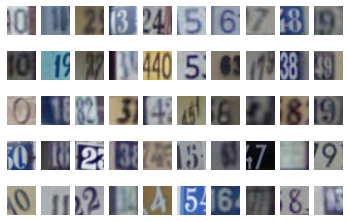

In [5]:
samples_per_class = 5  # Number of samples per class to visualize
plot_index = 1
for example_index in range(samples_per_class):
    for class_index in range(10):
        plt.subplot(5, 10, plot_index)
        image = train_X[train_y == class_index][example_index]
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

# Сначала реализуем KNN для бинарной классификации

В качестве задачи бинарной классификации мы натренируем модель, которая будет отличать цифру 0 от цифры 9.

In [6]:
# First, let's prepare the labels and the source data

# Only select 0s and 9s
binary_train_mask = (train_y == 0) | (train_y == 9)
binary_train_X = train_X[binary_train_mask]
binary_train_y = train_y[binary_train_mask] == 0

binary_test_mask = (test_y == 0) | (test_y == 9)
binary_test_X = test_X[binary_test_mask]
binary_test_y = test_y[binary_test_mask] == 0

# Reshape to 1-dimensional array [num_samples, 32*32*3]
binary_train_X = binary_train_X.reshape(binary_train_X.shape[0], -1)
binary_test_X = binary_test_X.reshape(binary_test_X.shape[0], -1)

In [7]:
# Create the classifier and call fit to train the model
# KNN just remembers all the data
knn_classifier = KNN(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

## Пришло время написать код! 

Последовательно реализуйте функции `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops`
в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

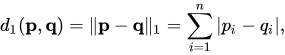

In [14]:
# TODO: implement compute_distances_two_loops in knn.py
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [15]:
# TODO: implement compute_distances_one_loop in knn.py
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))


ValueError: operands could not be broadcast together with shapes (121,3072) (3072,16) 

In [16]:
# TODO: implement compute_distances_no_loops in knn.py
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))


AssertionError: 

In [ ]:
# Lets look at the performance difference
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

In [1]:
# TODO: implement predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X)

NameError: name 'knn_classifier' is not defined

In [ ]:
# TODO: implement binary_classification_metrics in metrics.py
precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

In [ ]:
# Let's put everything together and run KNN with k=3 and see how we do
knn_classifier_3 = KNN(k=3)
knn_classifier_3.fit(binary_train_X, binary_train_y)
prediction = knn_classifier_3.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier_3.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

# Кросс-валидация (cross-validation)

Попробуем найти лучшее значение параметра k для алгоритма KNN! 

Для этого мы воспользуемся k-fold cross-validation (https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation). Мы разделим тренировочные данные на 5 фолдов (folds), и по очереди будем использовать каждый из них в качестве проверочных данных (validation data), а остальные -- в качестве тренировочных (training data).

В качестве финальной оценки эффективности k мы усредним значения F1 score на всех фолдах.
После этого мы просто выберем значение k с лучшим значением метрики.

*Бонус*: есть ли другие варианты агрегировать F1 score по всем фолдам? Напишите плюсы и минусы в клетке ниже.

In [ ]:
# Find the best k using cross-validation based on F1 score
num_folds = 5
train_folds_X = []
train_folds_y = []

# TODO: split the training data in 5 folds and store them in train_folds_X/train_folds_y

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_f1 = {}  # dict mapping k values to mean F1 scores (int -> float)

for k in k_choices:
    # TODO: perform cross-validation
    # Go through every fold and use it for testing and all other folds for training
    # Perform training and produce F1 score metric on the validation dataset
    # Average F1 from all the folds and write it into k_to_f1

    pass

for k in sorted(k_to_f1):
    print('k = %d, f1 = %f' % (k, k_to_f1[k]))

### Проверим, как хорошо работает лучшее значение k на тестовых данных (test data)

In [ ]:
# TODO Set the best k to the best value found by cross-validation
best_k = 1

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(binary_train_X, binary_train_y)
prediction = best_knn_classifier.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("Best KNN with k = %s" % best_k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

# Многоклассовая классификация (multi-class classification)

Переходим к следующему этапу - классификации на каждую цифру.

In [ ]:
# Now let's use all 10 classes
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)

knn_classifier = KNN(k=1)
knn_classifier.fit(train_X, train_y)

In [ ]:
# TODO: Implement predict_labels_multiclass
predict = knn_classifier.predict(test_X)

In [ ]:
# TODO: Implement multiclass_accuracy
accuracy = multiclass_accuracy(predict, test_y)
print("Accuracy: %4.2f" % accuracy)

Снова кросс-валидация. Теперь нашей основной метрикой стала точность (accuracy), и ее мы тоже будем усреднять по всем фолдам.

In [ ]:
# Find the best k using cross-validation based on accuracy
num_folds = 5
train_folds_X = []
train_folds_y = []

# TODO: split the training data in 5 folds and store them in train_folds_X/train_folds_y

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_accuracy = {}

for k in k_choices:
    # TODO: perform cross-validation
    # Go through every fold and use it for testing and all other folds for validation
    # Perform training and produce accuracy metric on the validation dataset
    # Average accuracy from all the folds and write it into k_to_accuracy
    pass

for k in sorted(k_to_accuracy):
    print('k = %d, accuracy = %f' % (k, k_to_accuracy[k]))

### Финальный тест - классификация на 10 классов на тестовой выборке (test data)

Если все реализовано правильно, вы должны увидеть точность не менее **0.2**.

In [ ]:
# TODO Set the best k as a best from computed
best_k = 1

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(train_X, train_y)
prediction = best_knn_classifier.predict(test_X)

# Accuracy should be around 20%!
accuracy = multiclass_accuracy(prediction, test_y)
print("Accuracy: %4.2f" % accuracy)